In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1= pd.read_csv("../input/sunpharmastockdata/PreviousDayClose.csv", index_col= "Date", parse_dates= True)
df1.head()

,Open,High,Low,Close,Adj Close,Volume,Growth% of Close from previous day
Date,,,,,,,
2009-12-02,156.399994,160.000000,148.660004,149.720001,140.133011,4689480.0,-2.772910
2009-12-03,150.014999,152.100006,148.750000,149.475006,139.903687,2534030.0,-0.163635
2009-12-04,148.500000,150.880005,145.110001,148.270004,138.775833,1216690.0,-0.806156
2009-12-07,148.509995,149.789993,144.110001,145.190002,135.893051,1559620.0,-2.077293
2009-12-08,145.300003,148.199997,144.535004,146.479996,137.100494,1795420.0,0.888487


<AxesSubplot:title={'center':'Sunpharma Closing price'}, xlabel='Date'>

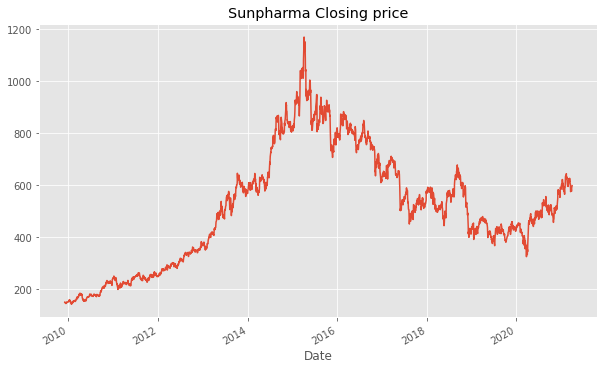

In [3]:
plt.style.use("ggplot")

df1["Close"].plot(label="Close", title="Sunpharma Closing price", figsize=(10,6))

## Data Preprocessing...  

In [4]:
# Features and Target segmentation
features = df1.iloc[:, :-1]
target = df1.iloc[:, 6:7] 

In [5]:
# Data Normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = mm.fit_transform(features)
y_mm = mm.fit_transform(target) 

In [6]:
# To get back in original form, we need to perform follwing operation
mm.inverse_transform(y_mm)

array([[-2.77290984],
       [-0.16363545],
       [-0.80615618],
       ...,
       [-1.63163988],
       [ 1.98871246],
       [ 1.7881471 ]])

In [7]:
X_ss.shape

(2786, 6)

In [8]:
len(X_ss)

2786

In [9]:
# last 30 for testing

X_train = X_ss[:2756, :]
X_test = X_ss[2756:, :]

y_train = y_mm[:2756, :]
y_test = y_mm[2756:, :]

In [10]:
# Printing shapes
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (2756, 6) (2756, 1)
Testing Shape (30, 6) (30, 1)


In [11]:
# Importing dependencies
import torch 
import torch.nn as nn
from torch.autograd import Variable 

In [12]:
X_train_tensors = Variable(torch.Tensor(X_train)).cuda()
X_test_tensors = Variable(torch.Tensor(X_test)).cuda()

y_train_tensors = Variable(torch.Tensor(y_train)).cuda()
y_test_tensors = Variable(torch.Tensor(y_test)) .cuda()

In [13]:
# Reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))


# Printing shapes 
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([2756, 1, 6]) torch.Size([2756, 1])
Testing Shape torch.Size([30, 1, 6]) torch.Size([30, 1])


## Network Defination....

In [19]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.seq_length = seq_length # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 1
        self.fc = nn.Linear(128, num_classes) # fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        output = output.view(-1, self.hidden_size) # reshaping the output for fc layer
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

## Important parameters.... 

In [15]:
num_epochs = 75000 
learning_rate = 0.001 

input_size = 6 # number of features
hidden_size = 3 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes(coz regression)

In [20]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).cuda() #our lstm class

In [21]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

## Training Loop.... 

In [22]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.19381
Epoch: 100, loss: 0.00533
Epoch: 200, loss: 0.00533
Epoch: 300, loss: 0.00533
Epoch: 400, loss: 0.00533
Epoch: 500, loss: 0.00533
Epoch: 600, loss: 0.00533
Epoch: 700, loss: 0.00533
Epoch: 800, loss: 0.00532
Epoch: 900, loss: 0.00532
Epoch: 1000, loss: 0.00532
Epoch: 1100, loss: 0.00531
Epoch: 1200, loss: 0.00531
Epoch: 1300, loss: 0.00531
Epoch: 1400, loss: 0.00530
Epoch: 1500, loss: 0.00530
Epoch: 1600, loss: 0.00528
Epoch: 1700, loss: 0.00519
Epoch: 1800, loss: 0.00240
Epoch: 1900, loss: 0.00190
Epoch: 2000, loss: 0.00184
Epoch: 2100, loss: 0.00181
Epoch: 2200, loss: 0.00180
Epoch: 2300, loss: 0.00178
Epoch: 2400, loss: 0.00177
Epoch: 2500, loss: 0.00175
Epoch: 2600, loss: 0.00169
Epoch: 2700, loss: 0.00162
Epoch: 2800, loss: 0.00155
Epoch: 2900, loss: 0.00150
Epoch: 3000, loss: 0.00147
Epoch: 3100, loss: 0.00143
Epoch: 3200, loss: 0.00140
Epoch: 3300, loss: 0.00138
Epoch: 3400, loss: 0.00137
Epoch: 3500, loss: 0.00136
Epoch: 3600, loss: 0.00135
Epoch: 3700, 

Epoch: 29700, loss: 0.00115
Epoch: 29800, loss: 0.00114
Epoch: 29900, loss: 0.00115
Epoch: 30000, loss: 0.00115
Epoch: 30100, loss: 0.00114
Epoch: 30200, loss: 0.00114
Epoch: 30300, loss: 0.00114
Epoch: 30400, loss: 0.00114
Epoch: 30500, loss: 0.00114
Epoch: 30600, loss: 0.00114
Epoch: 30700, loss: 0.00114
Epoch: 30800, loss: 0.00114
Epoch: 30900, loss: 0.00114
Epoch: 31000, loss: 0.00114
Epoch: 31100, loss: 0.00114
Epoch: 31200, loss: 0.00114
Epoch: 31300, loss: 0.00114
Epoch: 31400, loss: 0.00114
Epoch: 31500, loss: 0.00114
Epoch: 31600, loss: 0.00113
Epoch: 31700, loss: 0.00114
Epoch: 31800, loss: 0.00113
Epoch: 31900, loss: 0.00113
Epoch: 32000, loss: 0.00113
Epoch: 32100, loss: 0.00113
Epoch: 32200, loss: 0.00113
Epoch: 32300, loss: 0.00113
Epoch: 32400, loss: 0.00113
Epoch: 32500, loss: 0.00113
Epoch: 32600, loss: 0.00113
Epoch: 32700, loss: 0.00114
Epoch: 32800, loss: 0.00113
Epoch: 32900, loss: 0.00113
Epoch: 33000, loss: 0.00114
Epoch: 33100, loss: 0.00113
Epoch: 33200, loss: 

Epoch: 59000, loss: 0.00110
Epoch: 59100, loss: 0.00109
Epoch: 59200, loss: 0.00110
Epoch: 59300, loss: 0.00109
Epoch: 59400, loss: 0.00110
Epoch: 59500, loss: 0.00109
Epoch: 59600, loss: 0.00109
Epoch: 59700, loss: 0.00109
Epoch: 59800, loss: 0.00109
Epoch: 59900, loss: 0.00109
Epoch: 60000, loss: 0.00109
Epoch: 60100, loss: 0.00109
Epoch: 60200, loss: 0.00109
Epoch: 60300, loss: 0.00109
Epoch: 60400, loss: 0.00109
Epoch: 60500, loss: 0.00109
Epoch: 60600, loss: 0.00109
Epoch: 60700, loss: 0.00109
Epoch: 60800, loss: 0.00109
Epoch: 60900, loss: 0.00110
Epoch: 61000, loss: 0.00109
Epoch: 61100, loss: 0.00109
Epoch: 61200, loss: 0.00109
Epoch: 61300, loss: 0.00109
Epoch: 61400, loss: 0.00110
Epoch: 61500, loss: 0.00109
Epoch: 61600, loss: 0.00109
Epoch: 61700, loss: 0.00109
Epoch: 61800, loss: 0.00109
Epoch: 61900, loss: 0.00110
Epoch: 62000, loss: 0.00109
Epoch: 62100, loss: 0.00109
Epoch: 62200, loss: 0.00109
Epoch: 62300, loss: 0.00109
Epoch: 62400, loss: 0.00109
Epoch: 62500, loss: 

## Testing the model... 

In [38]:
# For complete dataset

df_X_ss = X_ss #old transformers
df_y_mm = y_mm #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) # one in middle coz time stamp== 1

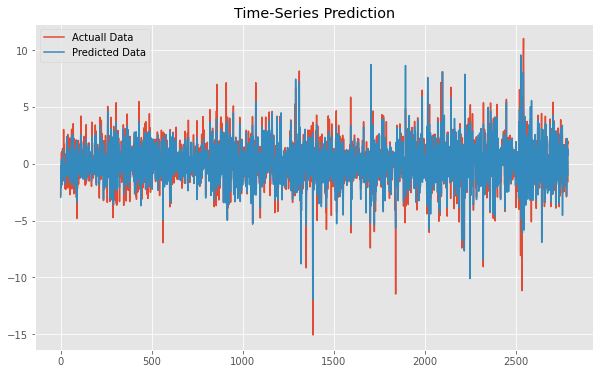

In [45]:
# On complete dataset

train_predict = lstm1(df_X_ss.cuda())#forward pass

data_predict = train_predict.data.cpu()
data_predict = data_predict.numpy() #numpy conversion

dataY_plot = df_y_mm.data.cpu()
dataY_plot = dataY_plot.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

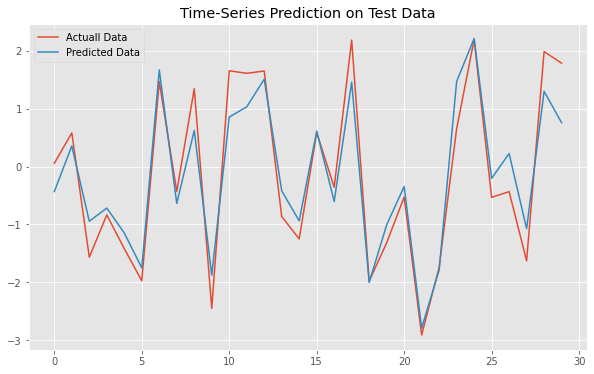

In [47]:
# Only on Test set

X_test= X_test_tensors_final.cuda()
y_test= y_test_tensors.cuda()


test_predict= lstm1(X_test) # Forward pass

predicted= test_predict.data.cpu()
predicted= predicted.numpy()

real_test= y_test.data.cpu()
real_test= real_test.numpy()


predicted= mm.inverse_transform(predicted)
real_test= mm.inverse_transform(real_test)

plt.figure(figsize=(10,6)) #plotting
plt.plot(real_test, label='Actuall Data') #actual plot
plt.plot(predicted, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction on Test Data')
plt.legend()
plt.show() 

## R2 score calculation over Test set...

In [48]:
from sklearn.metrics import r2_score
coefficient_of_dermination = r2_score(real_test, predicted)
print(coefficient_of_dermination)

0.8989323379384574


## Saving the model...

In [49]:
# Saving the LSTM model
torch.save(lstm1.state_dict(), "1DayDiff.pth")